In [ ]:
!pip install dataset-hub prophet -q

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet

from dataset_hub.timeseries import get_household_power

# Load dataset
household_power = get_household_power()
household_power.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
# Combine Date and Time into datetime
household_power["datetime"] = pd.to_datetime(household_power["Date"] + " " + household_power["Time"], dayfirst=True)
household_power = household_power.drop(["Date", "Time"], axis=1)

# Aggregate to monthly mean
monthly_power = household_power.resample("ME", on="datetime").mean().reset_index()

# Prepare data for Prophet
df_prophet = monthly_power[["datetime", "Global_active_power"]].rename(columns={"datetime": "ds", "Global_active_power": "y"})
df_prophet["y"] = df_prophet["y"].ffill()

# Drop incomplete last month
df_prophet = df_prophet.iloc[:-1]

# Split: train on all except last full month
train_df = df_prophet.iloc[:-1]
test_df = df_prophet.iloc[-1:]

## Part 1: Monthly forecast

00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:06 - cmdstanpy - INFO - Chain [1] done processing


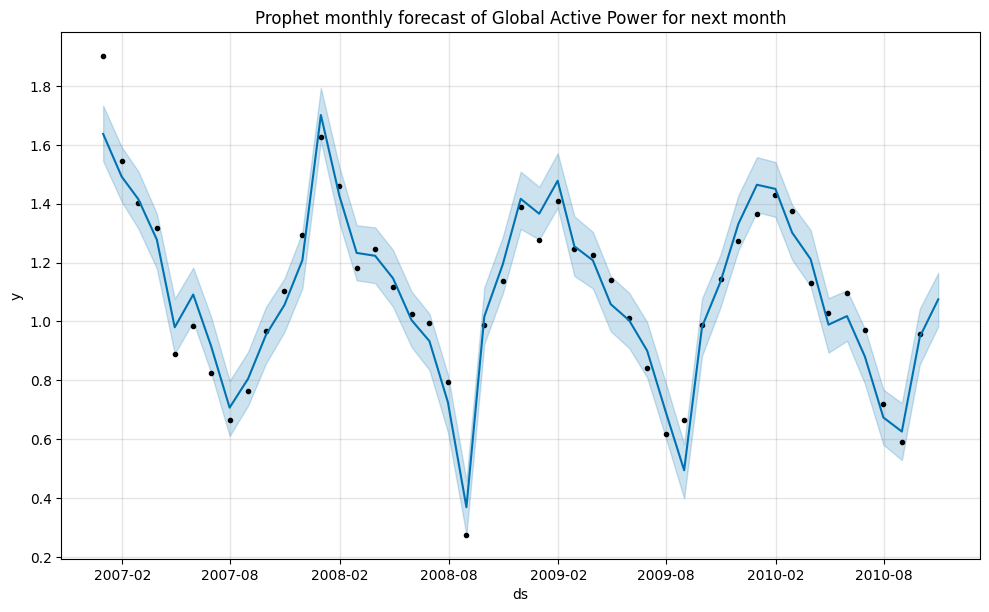

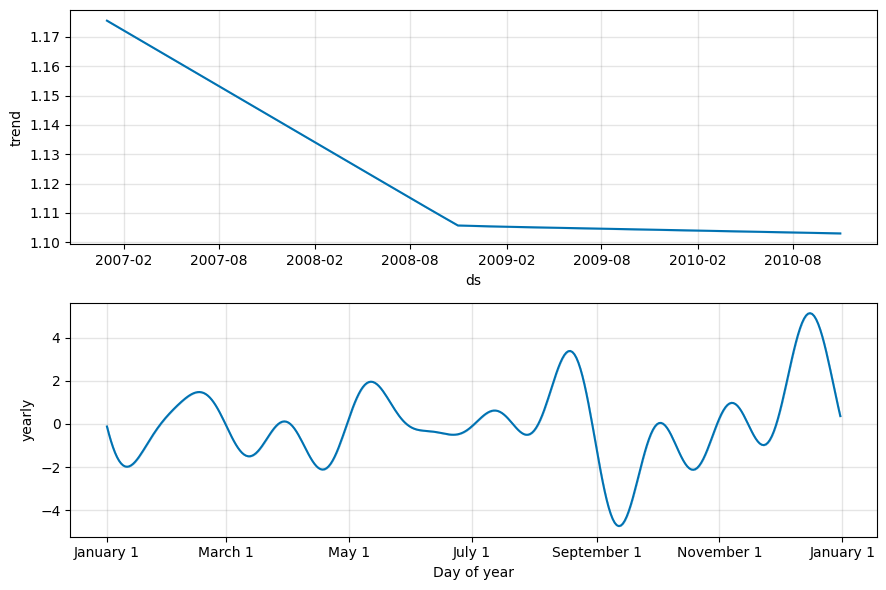

In [13]:
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.fit(train_df)

# Create future dataframe for next month
future = model.make_future_dataframe(periods=1, freq='ME')
forecast = model.predict(future)

# Plot monthly forecast
fig1 = model.plot(forecast)
plt.title("Prophet monthly forecast of Global Active Power for next month")
plt.show()

# Plot components (trend, yearly seasonality)
fig2 = model.plot_components(forecast, plot_cap = False)
plt.show()

## Part 2: Next month forecast error

In [14]:
# Predicted and actual for the last month
pred_total = forecast.iloc[-1]["yhat"]
actual_total = test_df["y"].values[0]

# Compute percentage error
percentage_error = np.abs((actual_total - pred_total) / actual_total) * 100

# Note: This is NOT a classical MAPE or robust model evaluation.
# We are showing the percentage error on a single month forecast as an illustrative example only.
print(f"Percentage error for next month forecast: {percentage_error:.2f}%")

Percentage error for next month forecast: 7.58%
